In [2]:
import pickle
import random
import math
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
#from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from sklearn.datasets import load_boston
from datetime import datetime
from datetime import timedelta
%matplotlib inline
# plt.matplotlib.rcParams.update({'font.size': 50})
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'   
plt.rcParams["patch.force_edgecolor"] = False
plt.rc('figure', titlesize=25)

In [5]:
PICKLE_PATH = '../augmented_datasets/pickles/hopkins_conf_gf0904_GDP_urban.pkl'
NEW_PICKLE_PATH = '../augmented_datasets/pickles/hopkins_conf_gf0904_GDP_urban_weather.pkl'
OUTLIER_QUARTILES = (0.02, 0.98) # Min, max quartiles

In [14]:
def remove_outlier(df, range_, columns):
    low = range_[0]
    high = range_[1]
    qnt = df.quantile([low, high])
    data = df.copy()
    for col in list(columns):
        data[col] = \
            data[(data[col] > qnt.loc[low, col]) &\
               (data[col] < qnt.loc[high, col])][col]
    return data.dropna()

def calc_corrs_scatter(df, outliers=(0,0), gdp_thr=0, urb_thr=0, only_us=False,\
                       show_names=False, show_states=False, temp_outliers=(0,0)):

    targets = ['GF_Q1', 'GF_Q2', 'GF_Q3', 'first_7']

    for target in targets:
        print('Interval temp vs {0} correlations'.format(target))
        if outliers == (0,0):
            confs1 = df.copy()
        else:
            confs1 = remove_outlier(df, outliers, [target])
        if temp_outliers != (0,0):
            confs1 = remove_outlier(confs1, temp_outliers, ['avg_interval_tmp'])
        confs1.dropna(inplace=True)
        if only_us:
            confs1 = confs1[confs1['Country_Region'] == 'US']
        confs1 = confs1[confs1['GDP'] > gdp_thr]
        confs1 = confs1[confs1['Urbanization'] > urb_thr]       
        gf = confs1[target].loc[:,'data'].values.tolist()
        avg_int_tmp = confs1['avg_interval_tmp'].loc[:,'data'].values.tolist()

        corr_p1 = stats.pearsonr(gf, avg_int_tmp)
        corr_s1 = stats.spearmanr(gf, avg_int_tmp)

        print('n={0}'.format(len(gf)))
        print('Pearson: {0}\tp_value: {1}'.format(corr_p1[0], corr_p1[1]))
        print('Spearman: {0}\tp_value: {1}\n'.format(corr_s1[0], corr_s1[1]))

    if outliers == (0,0):
        confs1 = df.copy()
    else:
        confs1 = remove_outlier(df, outliers, ['GF_Q1'])
    if temp_outliers != (0,0):
        confs1 = remove_outlier(confs1, temp_outliers, ['avg_interval_tmp'])
    confs1.dropna(inplace=True)
    
    gf_q1_1 = confs1['GF_Q1'].loc[:,'data'].values.tolist()
    avg_int_tmp1 = confs1['avg_interval_tmp'].loc[:,'data'].values.tolist()

    fig, axes = plt.subplots(figsize=(15, 7))
    _ = axes.scatter(avg_int_tmp1, gf_q1_1)
    n = len(confs1)

    _ = axes.set_xlabel('avg interval temp')
    _ = axes.set_ylabel('Q1 GF')
    _ = axes.set_title('n={0}'.format(n))

    if show_names:
        countries1 = confs1['Country_Region'].loc[:,'data'].values.tolist()
        for i, txt in enumerate(countries1):
            _ = axes.annotate(txt, (avg_int_tmp1[i], gf_q1_1[i]))

    if show_states and not show_names:
        states1 = confs1['Province_State'].loc[:,'data'].values.tolist()
        for i, txt in enumerate(states1):
            _ = axes.annotate(txt, (avg_int_tmp1[i], gf_q1_1[i]))
def manual_WRS(gf_qx, df, temp_range):

    colds = df[df['avg_interval_tmp'] <= temp_range[0]]\
        [[gf_qx]]

    hots = df[df['avg_interval_tmp'] >= temp_range[1]]\
        [[gf_qx]]

    colds.reset_index(level=[0,1], drop=True, inplace=True)
    hots.reset_index(level=[0,1], drop=True, inplace=True)

    colds.rename(columns={gf_qx: ''}, inplace=True)
    hots.rename(columns={gf_qx: ''}, inplace=True)

    # manual WRS algorithm

    colds = colds.T
    hots = hots.T
    colds = colds.add_prefix('c')
    hots = hots.add_prefix('h')
    ranks = colds.join(hots, lsuffix='first').rank(axis=1)
    
    h_list = [sample for sample in ranks.columns if 'h' in sample]
    c_list = [sample for sample in ranks.columns if 'c' in sample]
    h_sum = ranks[h_list].sum(axis=1)
    c_sum = ranks[c_list].sum(axis=1)

    b = len(colds.columns)
    n = b + len(hots.columns)
    expected_cold_sum = (b * (n + 1)) / 2
    sigma = math.sqrt(b * (n - b) * (n + 1) / 12)

    sums_normal = stats.norm(loc=expected_cold_sum, scale=sigma)
    p_value = 1 - sums_normal.cdf(float(c_sum))
    
    size = {
           'colds': b,
           'hots': len(hots.columns)
           }
    
    return [expected_cold_sum, c_sum, p_value, sigma, size]

def print_manual_WRS(qx, qx_results):
    difference = qx_results[1] - qx_results[0]
    print('--------------------------------------------------')
    print('{} WRS (manual)'.format(qx))
    print('--------------------------------------------------')
    print(
         '# colds samples: {0}\n# of hots samples: {1}\n'
         'Expected mean for cold countries rank sum: {2}\n'
         'Attained mean for cold countries rank sum: {3}\n'
         'Sigma: {4}\n'
         '(Attained mean) - (Expected mean) = {5}\n'
         'p-value for this result is: {6}'
         .format(qx_results[4]['colds'], qx_results[4]['hots'], qx_results[0],\
                 qx_results[1], difference, qx_results[3], qx_results[2]))

def builtin_WRS(gf_qx, df, temp_range):
    colds = df[df['avg_interval_tmp'] <= temp_range[0]][gf_qx]
    hots = df[df['avg_interval_tmp'] >= temp_range[1]][gf_qx]
    colds.reset_index(level=[0,1], drop=True, inplace=True)
    hots.reset_index(level=[0,1], drop=True, inplace=True)
    t, p = stats.ranksums(colds, hots)
    size = {
           'colds': len(colds),
           'hots': len(hots)
           }
    return [t, p/2, size]

def print_builtin_WRS(qx, qx_results):
    print('--------------------------------------------------')
    print('{} WRS (built-in) '.format(qx))
    print('--------------------------------------------------')
    print('Statistic:\t{0}'.format(qx_results[0]))
    print('p-value:\t{0}'.format(qx_results[1]))
#     print('--------------------------------------------------')


def builtin_ttest(gf_qx, df, temp_range):
    colds = df[df['avg_interval_tmp'] <= temp_range[0]][gf_qx]
    hots = df[df['avg_interval_tmp'] >= temp_range[1]][gf_qx]
    colds.reset_index(level=[0,1], drop=True, inplace=True)
    hots.reset_index(level=[0,1], drop=True, inplace=True)
    t, p = stats.ttest_ind(colds, hots)
    size = {
           'colds': len(colds),
           'hots': len(hots)
           }
    return [t, p/2, size]


def print_builtin_ttest(qx, qx_results):
    print('--------------------------------------------------')
    print('{} TTest (built-in)'.format(qx))
    print('--------------------------------------------------')
    print('# colds: {0}\n# of hots: {1}'.format(qx_results[2]['colds'], qx_results[2]['hots']))
    print('Statistic:\t{0}'.format(qx_results[0]))
    print('p-value:\t{0}'.format(qx_results[1]))
    print('--------------------------------------------------')

def calc_wrs_ttest(df, temp_range):
    Q1_manual = manual_WRS('GF_Q1', df, temp_range)
    print_manual_WRS('Q1', Q1_manual)

    Q1_builtin = builtin_WRS('GF_Q1', df, temp_range)
    print_builtin_WRS('Q1', Q1_builtin)
    
    Q1_ttest = builtin_ttest('GF_Q1', df, temp_range)
    print_builtin_ttest('Q1', Q1_ttest)
    
#     Q3_manual = manual_WRS('GF_Q3', df)
#     print_manual_WRS('Q3', Q3_manual)

#     Q3_builtin = builtin_WRS('GF_Q3', df)
#     print_builtin_WRS('Q3', Q3_builtin)

#     Q3_ttest = builtin_ttest('GF_Q3', df)
#     print_builtin_ttest('Q3', Q3_ttest)     

In [7]:
hopkins_confirmed = pd.read_pickle(NEW_PICKLE_PATH)

In [8]:
PLAIN = {'df': hopkins_confirmed,
        'show_names': True
        }

OUTLIERS = {
            'df': hopkins_confirmed,
            'outliers': (0.02,0.98)
            }

GDP_URB1 = {
            'df': hopkins_confirmed,
            'outliers': (0.02,0.98),
            'gdp_thr': 30000,
            'urb_thr': 80
            }

GDP_URB2 = {
            'df': hopkins_confirmed,
            'outliers': (0.02,0.98),
            'gdp_thr': 36000,
            'urb_thr': 84
            }

GDP_URB3 = {
            'df': hopkins_confirmed,
            'outliers': (0.02,0.98),
            'gdp_thr': 43000,
            'urb_thr': 88
            }

US_ONLY = {
            'df': hopkins_confirmed,
            'outliers': (0.02,0.98),
            'only_us': True,
            'show_states': True
            }

TEMP_OUTLIERS = {
            'df': hopkins_confirmed,
            'outliers': (0.02,0.98),
            'temp_outliers': (0.1, 0.9)
            }

##### Discard all locations where count < 20, add interval weather data
No need to run this if youre opening NEW_PICKLE

In [9]:
coords = set(hopkins_confirmed.index.get_level_values(0).tolist())
discarded = 0
for coord in coords:
    cases = hopkins_confirmed.loc[coord]['Max_Cases']['data']
    if cases < 20:
        discarded += 1
        country = hopkins_confirmed.loc[coord]['Country_Region']['data']
        province = hopkins_confirmed.loc[coord]['Province_State']['data']
        print('Dropped {0}, {1}, {2} with {3} cases'.format(discarded, province, country, cases))
        hopkins_confirmed.drop(coord, level=0, inplace=True)
        continue
    try:
        last_rel_date = hopkins_confirmed.loc[coord]['last relevant date']['data']
        five_prcnt_date = hopkins_confirmed.loc[coord]['5%_Date']['data']

        five_prct_column = hopkins_confirmed.columns.get_loc(five_prcnt_date)
        last_rel_column = hopkins_confirmed.columns.get_loc(last_rel_date)
        interval = hopkins_confirmed[hopkins_confirmed.columns[five_prct_column:last_rel_column]]

        hopkins_confirmed.loc[coord, 'avg_interval_tmp']['data'] = interval.loc[coord].loc['avg_d_tmp'].mean()
        hopkins_confirmed.loc[coord, 'avg_interval_RH']['data'] = interval.loc[coord].loc['avg_d_RH'].mean()
    except KeyError as e:
        print('key error, {0}'.format(coord))

Remove nans

In [10]:
nan_countries = []
nan_first_7 = []
for column in hopkins_confirmed.columns:
    any_nan = hopkins_confirmed[column].loc[:, 'data'].isna().any()
    nulls = hopkins_confirmed[column].loc[:, 'data'].isna().tolist()
    if any_nan:
        size = len([nul for nul in nulls if nul])
        print('{0}: {1}, {2}'.format(column, any_nan, size))
        for i in range(len(nulls)):
            if column == 'Country_Region':
                nc = hopkins_confirmed['Country_Region'].index[i][0]
                nan_countries.append(nc)
            if column == 'first_7':
                nc = hopkins_confirmed['first_7'].index[i][0]
                nan_first_7.append(nc)
# hopkins_confirmed.drop(nan_first_7, level=0, inplace=True) # This was removed because it was buggy. the dropna is better and robust
hopkins_confirmed['Province_State'] = hopkins_confirmed['Province_State'].fillna('')
hopkins_confirmed.dropna(inplace=True)

Province_State: True, 137
first_7: True, 7


In [11]:
# hopkins_confirmed.to_pickle(NEW_PICKLE_PATH)
hopkins_confirmed.describe()
us_states = len(hopkins_confirmed[hopkins_confirmed['Country_Region'] == 'US'])
print('Of which {0} are US locations'.format(us_states))

,GDP,Urbanization,avg_m_tmp,avg_m_RH,avg_m_precip,avg_m_wind,Max_Cases,first_7,avg_interval_tmp,avg_interval_RH,...,3/29/2020,3/30/2020,3/31/2020,4/1/2020,4/2/2020,4/3/2020,4/4/2020,4/5/2020,4/6/2020,4/7/2020
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,...,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,52090.890353,74.345655,9.437621,70.902462,1.787219,11.821452,1697.803387,2.956743,12.756306,70.007057,...,801.333020,877.954845,973.146754,1065.435560,1168.716839,1275.482596,1402.503293,1498.430856,1593.976482,1697.771402
std,21121.453292,14.627599,7.605476,9.057977,1.680550,3.679917,14993.072453,1.775053,7.358585,10.131658,...,6814.353811,7483.586652,8312.659775,9136.641046,10074.017100,11074.739093,12233.869566,13114.647699,14028.638112,14993.075916
min,396.000000,14.338000,-16.824675,11.831169,0.000000,3.007246,20.000000,0.000000,-9.926087,8.444444,...,0.000000,0.000000,2.000000,2.000000,4.000000,4.000000,0.000000,0.000000,0.000000,17.000000
25%,46609.000000,66.300000,3.940260,66.883117,0.032987,9.331169,37.000000,1.707143,6.837778,66.533333,...,11.000000,13.000000,16.000000,18.000000,21.000000,23.500000,27.000000,30.500000,33.000000,37.000000
50%,55172.000000,75.100000,8.459740,72.558442,1.604928,11.415152,88.000000,2.666667,11.987500,71.666667,...,28.000000,33.000000,38.000000,44.000000,51.000000,58.000000,66.000000,73.000000,79.000000,88.000000
75%,61594.000000,86.200000,13.906494,76.493506,2.681688,14.015584,308.500000,4.000000,17.919048,76.281746,...,118.000000,135.000000,152.000000,173.500000,203.500000,222.000000,251.000000,265.500000,286.000000,308.500000
max,200277.000000,100.000000,32.323377,88.608696,7.818052,29.774026,396223.000000,11.000000,35.100000,94.000000,...,140909.000000,161837.000000,188172.000000,213372.000000,243616.000000,275586.000000,308850.000000,337072.000000,366667.000000,396223.000000


Of which 863 are US locations


###### CORRELATIONS AND SCATTER PLOTS PER GF
Even after screening for place where confirmed cases > 20 we still get episodes where GF_Q1 or GF_Q3 equals zero
For this reason we remove the outliers and compute correlations for each GF seperatly

GDP and URB refference :
* MEAN   - 22914, 67
* USA    - 62794, 82
* ISRAEL - 41715, 92
* FRANCE - 41463, 80

AVG_INT_TEMP refference :
* MEAN   - 12.75
* Q1     - 6.83
* Q3.    - 17.91

###### No filters - all data

Interval temp vs GF_Q1 correlations
n=1063
Pearson: -0.026928004999385944	p_value: 0.3804441845809188
Spearman: -0.012499373729867211	p_value: 0.6839624400469957

Interval temp vs GF_Q2 correlations
n=1063
Pearson: 0.025432491113980573	p_value: 0.4074716267322436
Spearman: 0.020973988036079257	p_value: 0.4945437885112096

Interval temp vs GF_Q3 correlations
n=1063
Pearson: 0.05331188033862094	p_value: 0.08232469396481172
Spearman: 0.06294159313329731	p_value: 0.0401941828269001

Interval temp vs first_7 correlations
n=1063
Pearson: -0.025615159479384732	p_value: 0.404110387671027
Spearman: -0.034133158052900806	p_value: 0.266189218951124



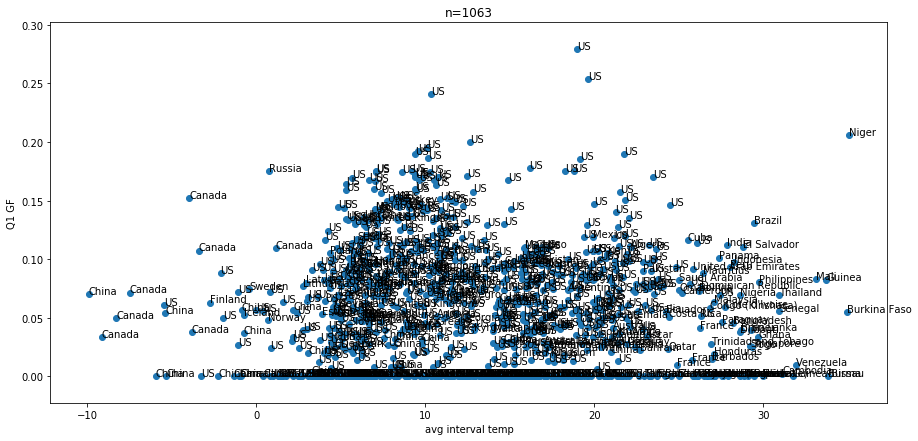

In [179]:
calc_corrs_scatter(**PLAIN)

###### No outliers - 0.02, 0.98

Interval temp vs GF_Q1 correlations
n=746
Pearson: -0.08841937180043247	p_value: 0.015705795721003033
Spearman: -0.06154558651124086	p_value: 0.09300238443406957

Interval temp vs GF_Q2 correlations
n=988
Pearson: -0.002451808924221826	p_value: 0.9386482383023877
Spearman: 0.007751119045941457	p_value: 0.807748196214509

Interval temp vs GF_Q3 correlations
n=1019
Pearson: 0.019980084960691986	p_value: 0.5240723236610649
Spearman: 0.04289368573710047	p_value: 0.17125201713365068

Interval temp vs first_7 correlations
n=1018
Pearson: -0.013987871445247558	p_value: 0.6557618874679227
Spearman: -0.03270582141062625	p_value: 0.29717415594888874



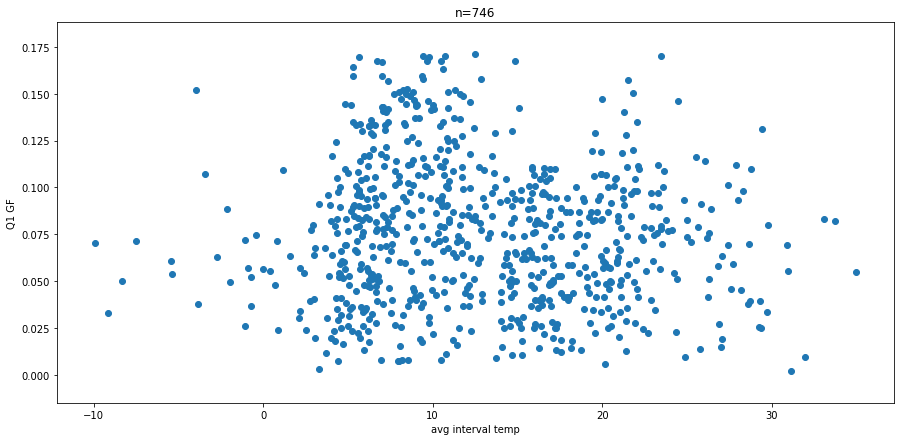

In [180]:
calc_corrs_scatter(**OUTLIERS)

###### GDP 30K, URB 80

Interval temp vs GF_Q1 correlations
n=275
Pearson: -0.06773677314948234	p_value: 0.2629452484286351
Spearman: -0.01791515132984786	p_value: 0.7674136196633171

Interval temp vs GF_Q2 correlations
n=353
Pearson: 0.037116859809409736	p_value: 0.48697471227124045
Spearman: 0.06926258680192808	p_value: 0.1941946258704375

Interval temp vs GF_Q3 correlations
n=361
Pearson: 0.019811274820663194	p_value: 0.7075521936182605
Spearman: 0.039910360014079396	p_value: 0.44966825715165304

Interval temp vs first_7 correlations
n=355
Pearson: -0.0583750315071296	p_value: 0.27267355329710474
Spearman: -0.05373332558653493	p_value: 0.3127002391095288



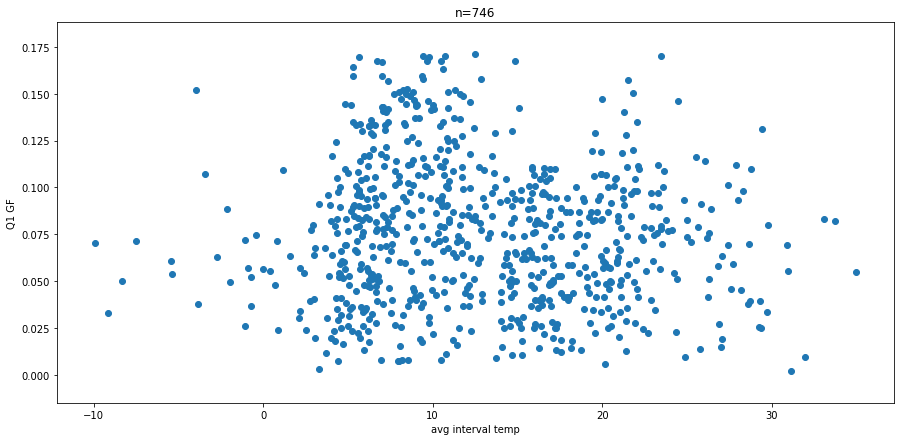

In [183]:
calc_corrs_scatter(**GDP_URB1)

###### GDP 36K, URB 84

Interval temp vs GF_Q1 correlations
n=247
Pearson: -0.04321985625260414	p_value: 0.498962029089166
Spearman: 0.012899335293962401	p_value: 0.8401442210410421

Interval temp vs GF_Q2 correlations
n=311
Pearson: 0.05260089286938899	p_value: 0.35520953890623475
Spearman: 0.0824182077110009	p_value: 0.14703725131827283

Interval temp vs GF_Q3 correlations
n=316
Pearson: 0.037046471981966686	p_value: 0.5117160424800054
Spearman: 0.053701058633488494	p_value: 0.3413432053458674

Interval temp vs first_7 correlations
n=313
Pearson: -0.07741864234243188	p_value: 0.1718614781253623
Spearman: -0.06126416541750371	p_value: 0.2798962320866449



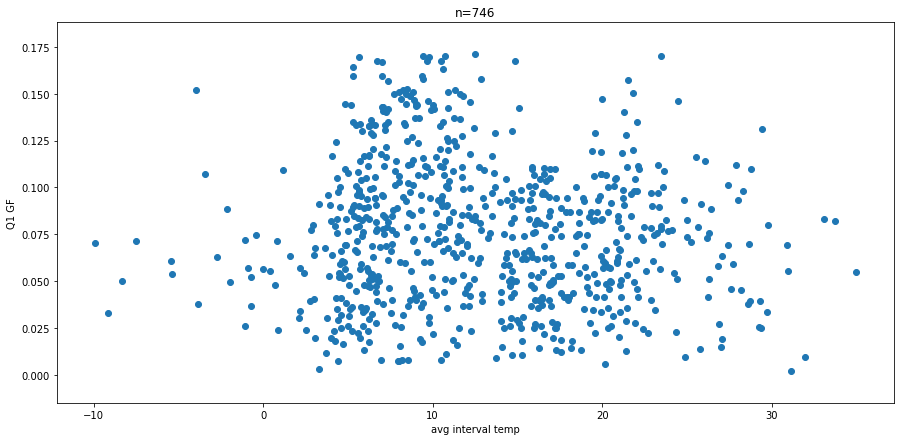

In [184]:
calc_corrs_scatter(**GDP_URB2)

###### GDP 43K, URB 88

Interval temp vs GF_Q1 correlations
n=132
Pearson: -0.22788416586684526	p_value: 0.008589871828452281
Spearman: -0.2486769657041069	p_value: 0.004037513842014917

Interval temp vs GF_Q2 correlations
n=159
Pearson: -0.06411932200829933	p_value: 0.42199713685801266
Spearman: -0.08471213787979484	p_value: 0.2883896617470962

Interval temp vs GF_Q3 correlations
n=160
Pearson: -0.013631925232406344	p_value: 0.8641548168133216
Spearman: 0.0005962522553870466	p_value: 0.9940295446449015

Interval temp vs first_7 correlations
n=160
Pearson: -0.10238236402327192	p_value: 0.19764855985115173
Spearman: -0.13091140372962995	p_value: 0.09893513494913452



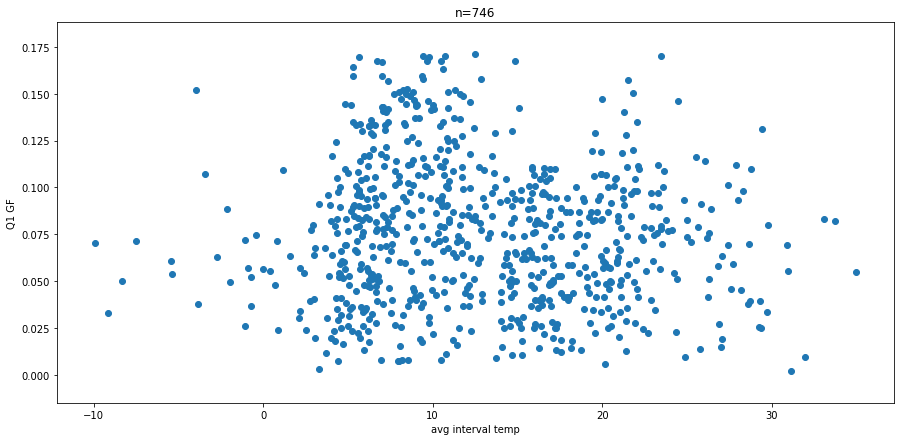

In [216]:
calc_corrs_scatter(**GDP_URB3)

###### US only

Interval temp vs GF_Q1 correlations
n=590
Pearson: -0.04759897640211598	p_value: 0.24834539969741382
Spearman: -0.030837968096078288	p_value: 0.45467676256700873

Interval temp vs GF_Q2 correlations
n=802
Pearson: 0.06919526578685918	p_value: 0.05012749194444051
Spearman: 0.060804618961131714	p_value: 0.08527451401380204

Interval temp vs GF_Q3 correlations
n=837
Pearson: 0.09556424761845268	p_value: 0.005658035004838538
Spearman: 0.10270393216478278	p_value: 0.002932258849475998

Interval temp vs first_7 correlations
n=824
Pearson: -0.0071236185641402145	p_value: 0.8382140183824958
Spearman: -0.0009318680413548179	p_value: 0.9786918000006751



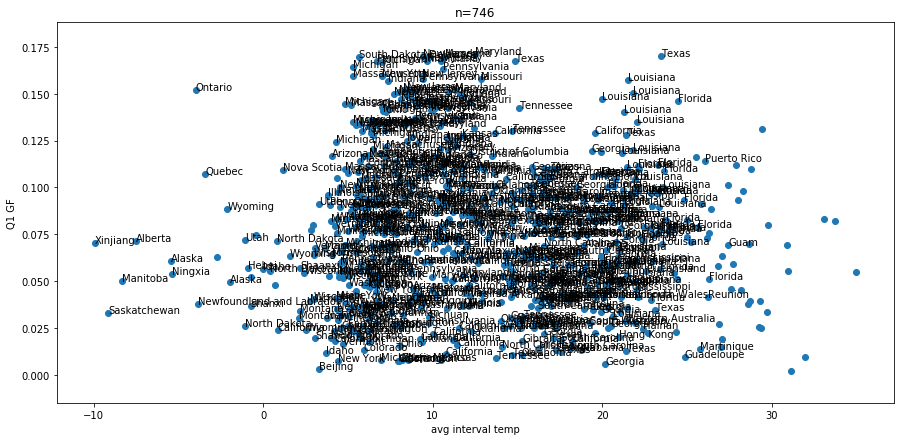

In [203]:
calc_corrs_scatter(**US_ONLY)

###### TEMP OUTLIERS 0.1, 0.9

Interval temp vs GF_Q1 correlations
n=606
Pearson: -0.1625033347903256	p_value: 5.8485664602438275e-05
Spearman: -0.13548592252405678	p_value: 0.0008263629227815564

Interval temp vs GF_Q2 correlations
n=792
Pearson: -0.018833949363476783	p_value: 0.5966361223390795
Spearman: -0.033259976406558436	p_value: 0.349891913413219

Interval temp vs GF_Q3 correlations
n=818
Pearson: 0.049557171629599966	p_value: 0.156754283936919
Spearman: 0.04821580546043078	p_value: 0.16829645070359978

Interval temp vs first_7 correlations
n=815
Pearson: -0.08354509845202648	p_value: 0.017052511701734274
Spearman: -0.08502120763593216	p_value: 0.01518758544971815



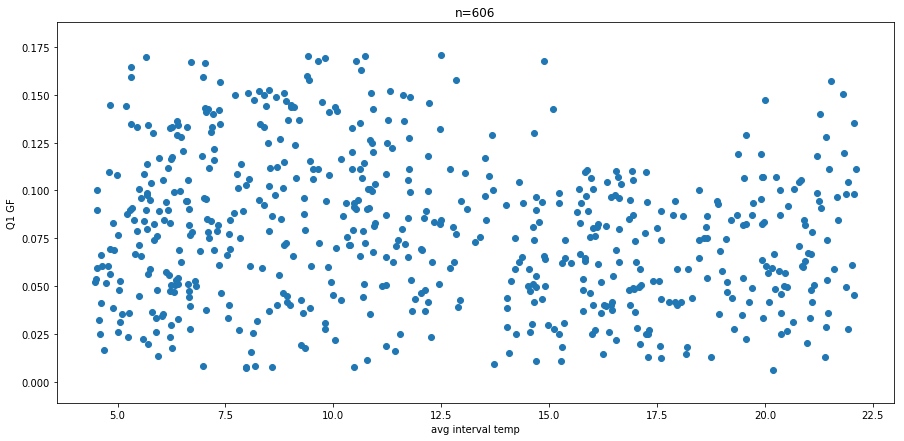

In [217]:
calc_corrs_scatter(**TEMP_OUTLIERS)

###### Rank sum
We regard two groups - 'cold' and 'hot' groups.
Each group's score is it's Q3 infection rate.
We will perform a Wilcoxon rank test and get a p-value for this arrangment

In [31]:
col = ['GF_Q1']
range_=(0.02,0.98)
gdp_th = 43000
urban_th = 88
# temp_range = (hopkins_confirmed['avg_interval_tmp'].quantile(0.1),\
#          hopkins_confirmed['avg_interval_tmp'].quantile(0.9))
temp_range = (10, 14)

hopkins_gdp_urban_th = hopkins_confirmed[hopkins_confirmed['GDP'] >= gdp_th].copy()
hopkins_gdp_urban_th = hopkins_gdp_urban_th[hopkins_gdp_urban_th['Urbanization'] >= urban_th].copy()
hopkins_without_outliers = remove_outlier(hopkins_confirmed, range_, [col])
hopkins_without_outliers.dropna(inplace=True)
len(hopkins_without_outliers)

746

In [52]:
print()
print('--------------------------------------------------')
print('--------------------------------------------------')
print("WRS and TTEST for data WITHOUT OUTLIERS")
print('--------------------------------------------------')

calc_wrs_ttest(hopkins_without_outliers, temp_range)




--------------------------------------------------
--------------------------------------------------
WRS and TTEST for data WITHOUT OUTLIERS
--------------------------------------------------
--------------------------------------------------
Q1 WRS (manual)
--------------------------------------------------
# colds samples: 306
# of hots samples: 324
Expected mean for cold countries rank sum: 96543.0
Attained mean for cold countries rank sum:     104566.5
dtype: float64
Sigma:     8023.5
dtype: float64
(Attained mean) - (Expected mean) = 2283.2700234532053
p-value for this result is: 0.00022067397193314964
--------------------------------------------------
Q1 WRS (built-in) 
--------------------------------------------------
Statistic:	3.51403903944103
p-value:	0.00022067397193317157
--------------------------------------------------
Q1 TTest (built-in)
--------------------------------------------------
# colds: 306
# of hots: 324
Statistic:	4.283587992511925
p-value:	1.063638381306

In [54]:
hopkins_gdp_urban_th_no_outliers = remove_outlier(hopkins_gdp_urban_th, range_, [col])

print()
print('--------------------------------------------------')
print('--------------------------------------------------')
print("WRS and TTEST for data WITHIN GDP URBAN THRESHOLDS, WITHOUT OUTLIERS")
print('--------------------------------------------------')

calc_wrs_ttest(hopkins_gdp_urban_th_no_outliers, temp_range)


--------------------------------------------------
--------------------------------------------------
WRS and TTEST for data WITHIN GDP URBAN THRESHOLDS, WITHOUT OUTLIERS
--------------------------------------------------
--------------------------------------------------
Q1 WRS (manual)
--------------------------------------------------
# colds samples: 63
# of hots samples: 50
Expected mean for cold countries rank sum: 3591.0
Attained mean for cold countries rank sum:     4250.5
dtype: float64
Sigma:     659.5
dtype: float64
(Attained mean) - (Expected mean) = 172.98843892006195
p-value for this result is: 6.881376852196919e-05
--------------------------------------------------
Q1 WRS (built-in) 
--------------------------------------------------
Statistic:	3.8123934993410473
p-value:	6.881376852195119e-05
--------------------------------------------------
Q1 TTest (built-in)
--------------------------------------------------
# colds: 63
# of hots: 50
Statistic:	4.062907200002554
p-

In [1]:
colds = hopkins_confirmed[hopkins_confirmed['avg_interval_tmp'] <= 15][['Country_Region', 'avg_interval_tmp','GF_Q1', 'GF_Q3', 'GDP', 'Urbanization']]
# print(colds.head())
colds = colds[colds['GDP'] > gdp_th]
colds = colds[colds['Urbanization'] > urban_th]


hots = hopkins_confirmed[hopkins_confirmed['avg_interval_tmp'] >= 25][['Country_Region', 'avg_interval_tmp','GF_Q1', 'GF_Q3', 'GDP', 'Urbanization']]
hots = hots[hots['GDP'] >= gdp_th][['Country_Region', 'avg_interval_tmp','GF_Q1', 'GF_Q3', 'GDP', 'Urbanization']]
hots = hots[hots['Urbanization'] >= urban_th][['Country_Region', 'avg_interval_tmp','GF_Q1', 'GF_Q3', 'GDP', 'Urbanization']]


colds.reset_index(level=[0,1], drop=True, inplace=True)
hots.reset_index(level=[0,1], drop=True, inplace=True)

fig, axes = plt.subplots(figsize=(15, 7))
axes.scatter(colds['avg_interval_tmp'], colds['GF_Q1'])
axes.scatter(colds['avg_interval_tmp'], colds['GF_Q3'])
axes.scatter(hots['avg_interval_tmp'], hots['GF_Q1'])
axes.scatter(hots['avg_interval_tmp'], hots['GF_Q3'])

axes.set_xlabel('Average Interval Temperature', fontsize='large')
axes.set_ylabel('Growth Factor', fontsize='large')
axes.set_title('Colds and Hots in Q1 and Q3 - within GDP and urbanization thresholds - WITH OUTLIERS'.format(n))
axes.legend(['Cold - Q1', 'Cold - Q3', 'Hot - Q1', 'Hot - Q3'], fontsize='large')
# axes.text(7,  1.5556, 'Nebraska', fontsize='large')
# axes.text(9,  1.8571, 'Iowa', fontsize='large')
# plt.text(2,4,'This text starts at point (2,4)')

# without outliers
colds_no_outliers = remove_outlier(colds,range_, [col])
hots_no_outliers = remove_outlier(hots,range_, [col])

fig, axes = plt.subplots(figsize=(15, 7))
axes.scatter(colds_no_outliers['avg_interval_tmp'], colds_no_outliers['GF_Q1'])
axes.scatter(colds_no_outliers['avg_interval_tmp'], colds_no_outliers['GF_Q3'])
axes.scatter(hots_no_outliers['avg_interval_tmp'], hots_no_outliers['GF_Q1'])
axes.scatter(hots_no_outliers['avg_interval_tmp'], hots_no_outliers['GF_Q3'])

axes.set_xlabel('Average Interval Temperature', fontsize='large')
axes.set_ylabel('Growth Factor', fontsize='large')
axes.set_title('Colds and Hots in Q1 and Q3 - within GDP and urbanization thresholds - WITHOUT OUTLIERS'.format(n))
axes.legend(['Cold - Q1', 'Cold - Q3', 'Hot - Q1', 'Hot - Q3'], fontsize='large')

NameError: name 'hopkins_confirmed' is not defined

In [25]:
print('--------------------------------------------------')
print('--------------------------------------------------')
print("WRS and TTEST for data WITH OUTLIERS")
print('--------------------------------------------------')

calc_wrs_ttest(hopkins_confirmed, temp_range)


--------------------------------------------------
--------------------------------------------------
WRS and TTEST for data WITH OUTLIERS
--------------------------------------------------


TypeError: calc_wrs_ttest() missing 1 required positional argument: 'temp_range'

In [20]:
print()
print('--------------------------------------------------')
print('--------------------------------------------------')
print("WRS and TTEST for data WITHIN GDP URBAN THRESHOLDS, WITH OUTLIERS")
print('--------------------------------------------------')

calc_wrs_ttest(hopkins_gdp_urban_th)


--------------------------------------------------
--------------------------------------------------
WRS and TTEST for data WITHIN GDP URBAN THRESHOLDS, WITH OUTLIERS
--------------------------------------------------
--------------------------------------------------
Q1 WRS (manual)
--------------------------------------------------
Expected mean for cold countries rank sum: 7371.0
Attained mean for cold countries rank sum:     7550.0
dtype: float64
Sigma: 99.13626985114983
(Attained mean) - (Expected mean) =     179.0
dtype: float64
p-value for this result is: 0.03549077520164401
--------------------------------------------------
Q1 WRS (built-in) 
--------------------------------------------------
Statistic:	1.8055954724619272
p-value:	0.035490775201643975
--------------------------------------------------
Q1 TTest (built-in)
--------------------------------------------------
Statistic:	1.793167043226482
p-value:	0.03770182014580103
------------------------------------------------